In [1]:
%matplotlib inline

from IPython.display import HTML
from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf

import hgail.misc.utils
import hgail.misc.simulation

import utils

In [17]:
# build session
tf.reset_default_graph()
sess = tf.InteractiveSession()

/data/akvasov/miniconda3/envs/rllab3/lib/python3.5/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [3]:
# load params, args, env, policy
#params_filepath = '/data/akvasov/ngsim_env/data/experiments/rails_smoothed_infogail_2000_2_fine/imitate/log/itr_88.npz'
params_filepath ='/data/akvasov/ngsim_env/data/experiments/NGSIM-gail/imitate/log/itr_999.npz'
params = hgail.misc.utils.load_params(params_filepath)
#args_filepath = "/data/akvasov/ngsim_env/data/experiments/rails_smoothed_infogail_2000_2_fine/imitate/log/args.npz"
args_filepath ='/data/akvasov/ngsim_env/data/experiments/NGSIM-gail/imitate/log/args.npz'
args = np.load(args_filepath)['args'].item()
env, _, _ = utils.build_ngsim_env(args, exp_dir='/tmp', alpha=0.)
normalizing_env = hgail.misc.utils.extract_normalizing_env(env)
normalizing_env._obs_mean = params['normalzing']['obs_mean']
normalizing_env._obs_var = params['normalzing']['obs_var']

/data/akvasov/miniconda3/envs/rllab3/lib/python3.5/site-packages/julia/core.py:689: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  FutureWarning,
/data/akvasov/miniconda3/envs/rllab3/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [11]:
args.env_multiagent

False

In [18]:
# load policy params
args.scheduler_k = 40
policy = utils.build_policy(args, env)
sess.run(tf.global_variables_initializer())
policy.set_param_values(params['policy'])

In [26]:
img.

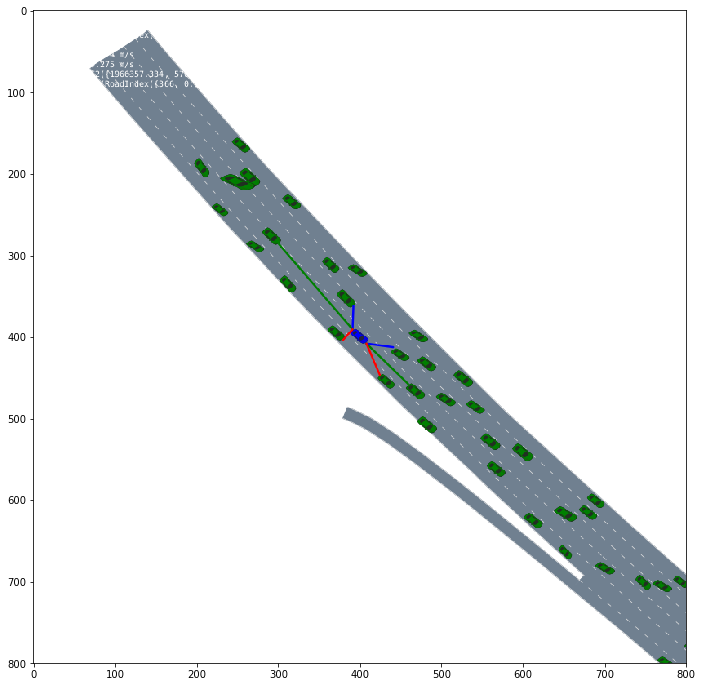

In [20]:
img = env.render(egocolor=[0.,0.,1.])
plt.figure(figsize=(12,12))
plt.imshow(img)
plt.show()

In [36]:
offset = 365
egoid = 2000
x = env.reset(offset=offset, egoid=egoid)
_,_,_,info = env.step(np.array([0.,0.]))
static_camera_pos = [info['x'], info['y']]


In [37]:
cmap = {
    0:[1.,0.,1.],
    1:[1.,0.,0.],
    2:[0.,0.,1.],
    3:[1.,1.,1.]
}   
def simulate(env, policy, max_steps, render=False, camtype='follow', static_camera_pos=[0.,0.], env_kwargs=dict()):
    traj = hgail.misc.simulation.Trajectory()
    x = env.reset(**env_kwargs)
    policy.reset()
    imgs = []
    for step in range(max_steps):
        a, a_info = policy.get_action(x)
        nx, r, done, e_info = env.step(a)
        if render: 
            c = cmap[np.argmax(a_info['latent'])]
            img = env.render(egocolor=c, camtype=camtype, static_camera_pos=static_camera_pos)
            imgs.append(img)
        traj.add(
            policy.observation_space.flatten(x), 
            a, 
            r, 
            a_info,
            e_info
        )
        if done: break
        x = nx
    return traj.flatten(), imgs

In [38]:
n_traj = 1
trajlist = []
imgslist = []
env.reset()
for traj_idx in range(n_traj):
    sys.stdout.write('\r{} / {}'.format(traj_idx + 1, n_traj))
    traj, imgs = simulate(
        env, 
        policy, 
        max_steps=args.scheduler_k, 
        render=True, 
        camtype='follow',
        static_camera_pos=static_camera_pos,
        env_kwargs=dict(offset=offset, egoid=egoid)
    )
    trajlist.append(traj)
    imgslist.append(imgs)

1 / 1

In [39]:
imgslist = np.array(imgslist)
imgs = imgslist.mean(0)
imgs.shape

(40, 800, 800, 4)

In [40]:
fig, ax = plt.subplots(figsize=(16,16))
img = plt.imshow(imgs[0])

def animate(i):
    img.set_data(imgs[i])
    return (img,)

anim = animation.FuncAnimation(
    fig, 
    animate, 
    frames=args.scheduler_k, 
    interval=100, 
    blit=True
)

HTML(anim.to_html5_video())

In [41]:
latents = []
xs = []
ys = []
ss = []
phis = []
for traj in trajlist:
    latents.append(np.argmax(traj['latent'], axis=1))
    xs.append(traj['x'] - traj['x'][0])
    ys.append(traj['y'] - traj['y'][0])
    ss.append(traj['s'])
    phis.append(traj['phi'])


In [42]:
latents

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]

/data/akvasov/miniconda3/envs/rllab3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


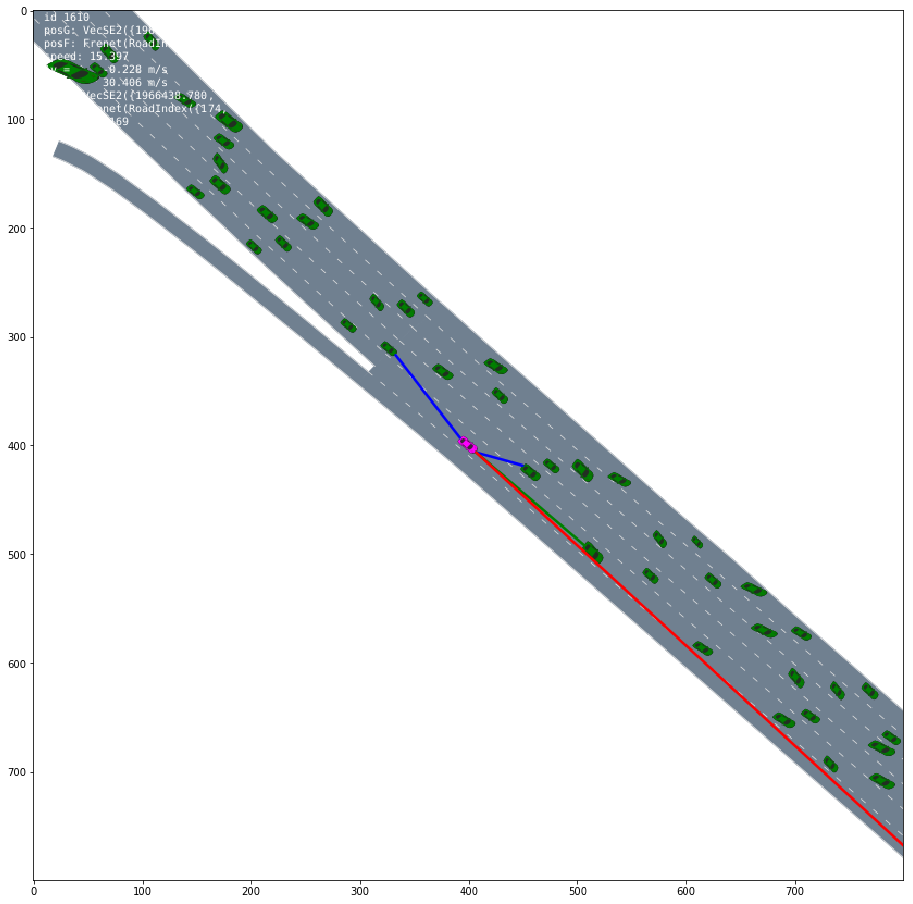

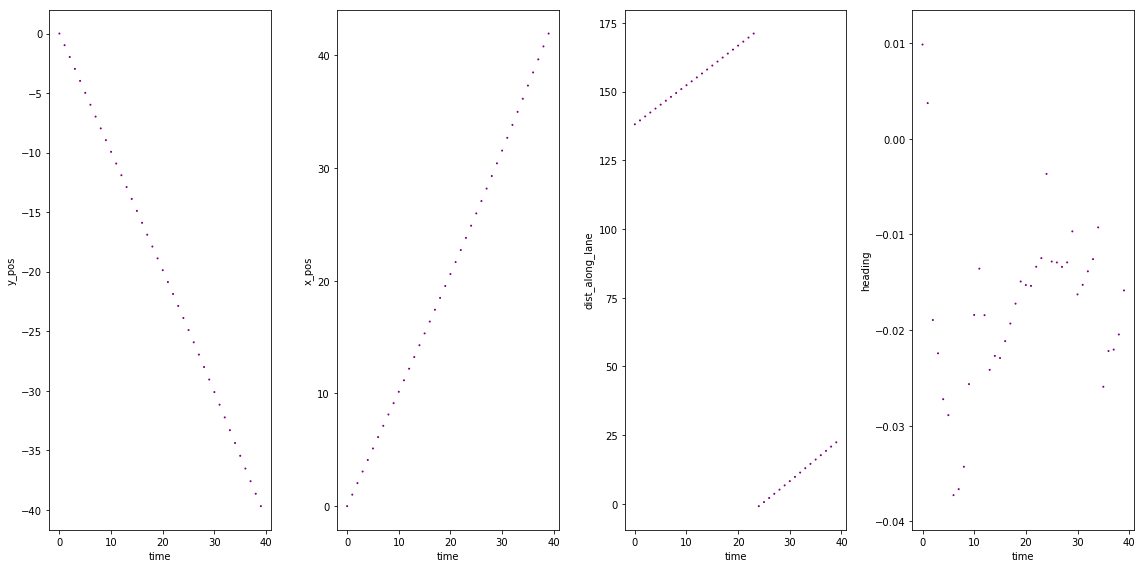

In [43]:
cmap = {
    0:'purple',
    1:'red',
    2:'blue',
    3:'green'
}   
colors = [[cmap[v] for v in latents[i]] for i in range(len(xs))]
labels = ['y_pos', 'x_pos', 'dist_along_lane', 'heading']
plt.figure(figsize=(16,8))
for j, vs in enumerate([ys, xs, ss, phis]):
    plt.subplot(1,4,j+1)
    plt.xlabel('time')
    plt.ylabel(labels[j])
    for i in range(len(xs)):
        plt.scatter(range(len(vs[i])), vs[i], c=colors[i], s=1)
plt.legend()
plt.tight_layout()
plt.show()